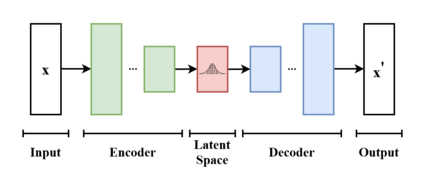
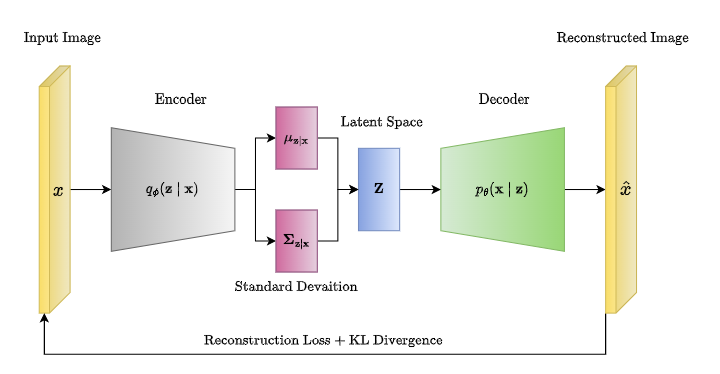
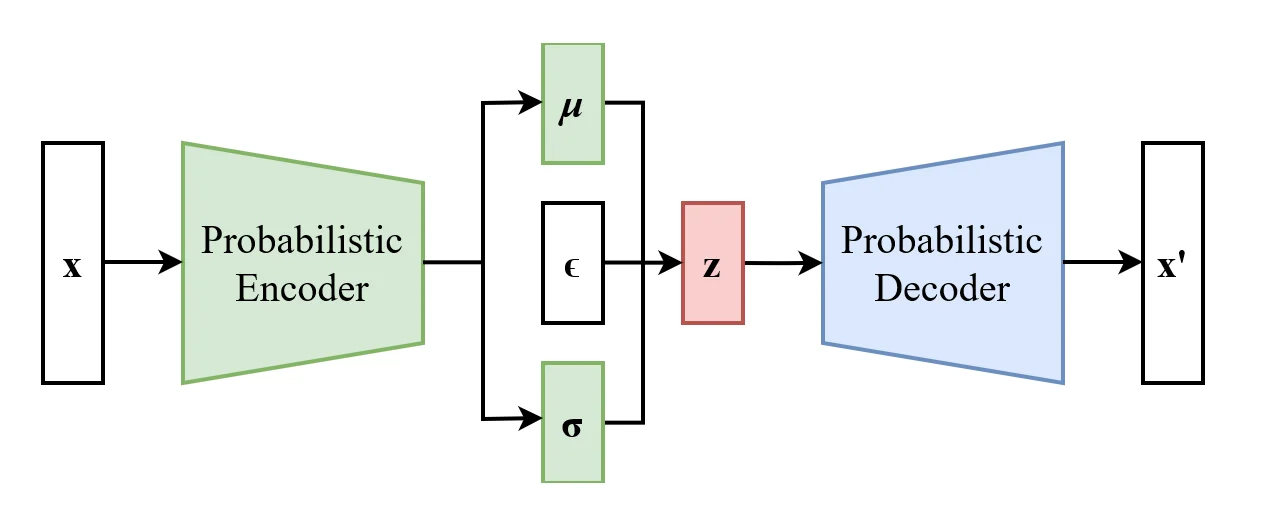
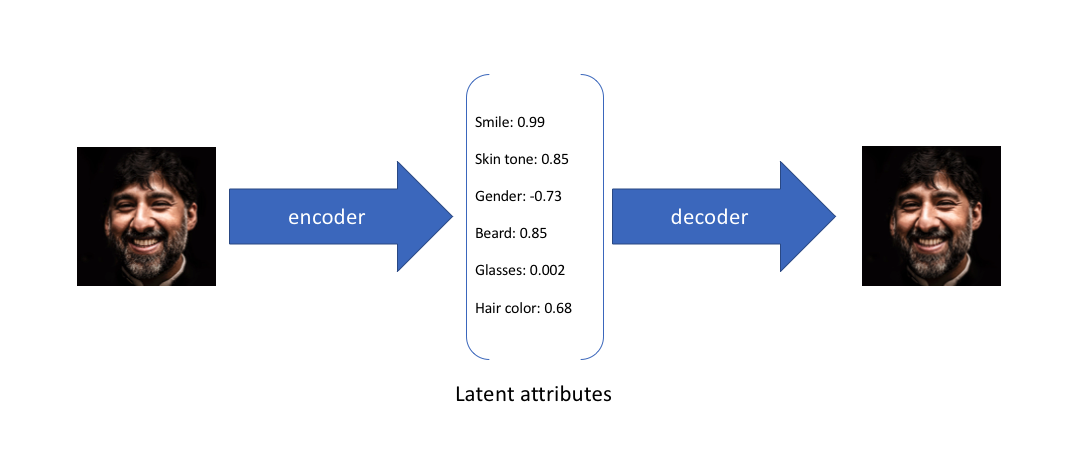

In [298]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
import os 
from PIL import Image

In [299]:
class Encoder(Model):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.convolution_01 = tf.keras.layers.Conv2D(
            32, (3, 3), strides=2, activation="relu", padding="same"
        )  # (75, 75, 32)
        self.convolution_02 = tf.keras.layers.Conv2D(
            64, (3, 3), strides=2, activation="relu", padding="same"
        )  # (38, 38, 64)
        self.convolution_03 = tf.keras.layers.Conv2D(
            128, (3, 3), strides=2, activation="relu", padding="same"
        )  # (19, 19, 128)
        self.convolution_04 = tf.keras.layers.Conv2D(
            256, (3, 3), strides=2, activation="relu", padding="same"
        )  # (10, 10, 256)
        self.flatten = tf.keras.layers.Flatten()
        self.fully_connected_01 = tf.keras.layers.Dense(units=512, activation="relu")
        self.mean_of_latent_distribution = tf.keras.layers.Dense(units=self.latent_dimension)
        self.log_variance_of_latent = tf.keras.layers.Dense(units=self.latent_dimension)
        
    def call(self, X):
        print(f"\nEncoding--------------")
        X = self.convolution_01(X)  # (75, 75, 32)
        print(f"After convolution_01: {X.shape}")
        X = self.convolution_02(X)  # (38, 38, 64)
        print(f"After convolution_02: {X.shape}")
        X = self.convolution_03(X)  # (19, 19, 128)
        print(f"After convolution_03: {X.shape}")
        X = self.convolution_04(X)  # (10, 10, 256)
        print(f"After convolution_04: {X.shape}")
        X = self.flatten(X)
        print(f"After flatten: {X.shape}")
        X = self.fully_connected_01(X)
        print(f"After fully_connected_01: {X.shape}")
        z_mean_of_latent_distribution = self.mean_of_latent_distribution(X)
        print(f"After mean_of_latent_distribution: {z_mean_of_latent_distribution.shape}")
        z_log_variance_of_latent = self.log_variance_of_latent(X)
        print(f"After log_variance_of_latent: {z_log_variance_of_latent.shape}")
        print(f"----------------------\n")
        return z_mean_of_latent_distribution, z_log_variance_of_latent

In [300]:
class Decoder(Model):
    def __init__(self, latent_dimension, number_of_channels=3):
        super(Decoder, self).__init__()
        self.number_of_channels = number_of_channels
        self.latent_dimension = latent_dimension
        self.fully_connected = tf.keras.layers.Dense(
            units=19 * 19 * 128, activation="relu"  
        )
        self.reshape = tf.keras.layers.Reshape((19, 19, 128))
        self.deconvolution_01 = tf.keras.layers.Conv2DTranspose(
            128, (4, 4), strides=2, activation="relu", padding="same"
        )  # (38, 38, 128)
        self.deconvolution_02 = tf.keras.layers.Conv2DTranspose(
            64, (4, 4), strides=2, activation="relu", padding="same"
        )  # (76, 76, 64)
        
        self.deconvolution_03 = tf.keras.layers.Conv2DTranspose(
            32, (4, 4), strides=2, activation="relu", padding="same"
        )  # (150, 150, 32)
        
        self.output_layer = tf.keras.layers.Conv2DTranspose(
            self.number_of_channels, (4, 4), activation="sigmoid", padding="same"
        )  # Final: (150, 150, 3)
        
    def call(self, z):
        print(f"\nDECODING: #############")
        X = self.fully_connected(z)
        X = self.reshape(X)
        print(f"After reshape: {X.shape}")
        X = self.deconvolution_01(X)
        print(f"After deconvolution 1: {X.shape}")
        X = self.deconvolution_02(X)
        print(f"After deconvolution 2: {X.shape}")
        X = self.deconvolution_03(X)
        print(f"After deconvolution 3: {X.shape}")
        X = self.output_layer(X)
        print(f"After output layer: {X.shape}")
        print(f"#########################\n")
        return X

In [301]:
# Sampling latent space
def sample_latent(z_mean_of_latent_distribution, z_log_variance_of_latent):
    batch = tf.shape(z_mean_of_latent_distribution)[0]
    dimension = tf.shape(z_mean_of_latent_distribution)[1]
    epsilon = tf.random.normal(shape=(batch, dimension))
    result = z_mean_of_latent_distribution + tf.exp(0.5 * z_log_variance_of_latent) * epsilon
    return result

def vae_loss(X, X_reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent):
    X_reconstructed_cropped = X_reconstructed[:, 1:-1, 1:-1, :]
    print("X shape:", X.shape)  # Should be (32, 150, 150, 3)
    print("X_reconstructed cropped shape:", X_reconstructed_cropped.shape)  # Should be (32, 150, 150, 3)
    
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(X, X_reconstructed_cropped), axis=[1, 2]
    ))

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
        1 + z_log_variance_of_latent - tf.square(z_mean_of_latent_distribution) - tf.exp(z_log_variance_of_latent), axis=1
    ))
    
    return reconstruction_loss + kl_loss

In [302]:
class VariationalAutoEncoder(Model):
    def __init__(self, latent_dimension, number_of_channels):
        super(VariationalAutoEncoder, self).__init__()
        self.number_of_channels = number_of_channels
        self.encoder = Encoder(latent_dimension)
        self.decoder = Decoder(latent_dimension, number_of_channels)
    
    def call(self, X):
        z_mean_of_latent_distribution, z_log_variance_of_latent = self.encoder(X)
        z = sample_latent(z_mean_of_latent_distribution, z_log_variance_of_latent)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent

In [303]:
def load_images(path_to_image_folder, image_width, image_height):
    files = os.listdir(path_to_image_folder)
    images = []
    for file_name in files:
        image = Image.open(os.path.join(path_to_image_folder, file_name)).convert("RGB")
        image = image.resize((image_width, image_height))
        image_array = np.array(image)
        images.append(image_array)
    return np.array(images)

X_train = load_images("./dataset/training-VAE/glacier/", 150, 150)
X_train = X_train / 255.0  # Normalization to [0, 1]

print(f"X shape: {X_train.shape}")  # Should be (num_images, 28, 28, 3)
print(f"X_train min and max = ({X_train.min()}, {X_train.max()})")  # Should be (0.0, 1.0)

X shape: (200, 150, 150, 3)
X_train min and max = (0.0, 1.0)


In [304]:
latent_dimension = 2
number_of_channels = 3
variational_autoencoder = VariationalAutoEncoder(latent_dimension, number_of_channels)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(X):
    with tf.GradientTape() as tape:
        X_reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent = variational_autoencoder(X)
        loss = vae_loss(X, X_reconstructed, z_mean_of_latent_distribution, z_log_variance_of_latent)
    gradients = tape.gradient(loss, variational_autoencoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, variational_autoencoder.trainable_variables))
    return loss

def train(epochs, batch_size, debug=False):
    train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(600).batch(batch_size)
    for epoch in range(epochs):
        for batch, id in zip(train_dataset, range(len(train_dataset))):
            loss = train_step(batch)
            if debug:
                print(f"{id}/{len(train_dataset)}, Loss: {loss:.2f}")
        print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

train(epochs=2, batch_size=32, debug=True)


Encoding--------------
After convolution_01: (32, 75, 75, 32)
After convolution_02: (32, 38, 38, 64)
After convolution_03: (32, 19, 19, 128)
After convolution_04: (32, 10, 10, 256)
After flatten: (32, 25600)
After fully_connected_01: (32, 512)
After mean_of_latent_distribution: (32, 2)
After log_variance_of_latent: (32, 2)
----------------------


Encoding--------------
After convolution_01: (32, 75, 75, 32)
After convolution_02: (32, 38, 38, 64)
After convolution_03: (32, 19, 19, 128)
After convolution_04: (32, 10, 10, 256)
After flatten: (32, 25600)
After fully_connected_01: (32, 512)
After mean_of_latent_distribution: (32, 2)
After log_variance_of_latent: (32, 2)
----------------------


DECODING: #############
After reshape: (32, 19, 19, 128)
After deconvolution 1: (32, 38, 38, 128)
After deconvolution 2: (32, 76, 76, 64)
After deconvolution 3: (32, 152, 152, 32)
After output layer: (32, 152, 152, 3)
#########################


DECODING: #############
After reshape: (32, 19, 19, 1

In [ ]:
def generate_images(model, n=20):
    random_latent_vectors = tf.random.normal(shape=(n, latent_dimension))  # n latent vectors
    generated_images = model.decoder(random_latent_vectors)
    generated_images = generated_images.numpy()
    
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(generated_images[i])  
        plt.axis("off")
    plt.savefig("vae_glacier_output.jpg")
    plt.show()

generate_images(variational_autoencoder, 60)


DECODING: #############
After reshape: (60, 19, 19, 128)
After deconvolution 1: (60, 38, 38, 128)
After deconvolution 2: (60, 76, 76, 64)
After deconvolution 3: (60, 152, 152, 32)
After output layer: (60, 152, 152, 3)
#########################

